<a href="https://colab.research.google.com/github/makoto0825/Image-Generation-by-DCGAN/blob/main/Image_Generation_by_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive/face3/images

0_2000.jpg     1900_2001.jpg  2800_2002.jpg  3700_2002.jpg  4603_2003.jpg
1000_2000.jpg  1901_2001.jpg  2801_2002.jpg  3701_2002.jpg  4604_2003.jpg
1001_2000.jpg  190_2000.jpg   280_2000.jpg   370_2000.jpg   4605_2003.jpg
100_2000.jpg   1902_2001.jpg  2802_2002.jpg  3702_2002.jpg  4606_2003.jpg
1002_2000.jpg  1903_2001.jpg  2803_2002.jpg  3703_2002.jpg  4607_2003.jpg
1003_2000.jpg  1904_2001.jpg  2804_2002.jpg  3704_2002.jpg  4608_2003.jpg
1004_2000.jpg  1905_2001.jpg  2805_2002.jpg  3705_2002.jpg  4609_2003.jpg
1005_2000.jpg  1906_2001.jpg  2806_2002.jpg  3706_2002.jpg  4610_2003.jpg
1006_2000.jpg  1907_2001.jpg  2807_2002.jpg  3707_2002.jpg  4611_2003.jpg
1007_2000.jpg  1908_2001.jpg  2808_2002.jpg  3708_2002.jpg  461_2000.jpg
1008_2000.jpg  1909_2001.jpg  2809_2002.jpg  3709_2002.jpg  4612_2003.jpg
1009_2000.jpg  1910_2001.jpg  2810_2002.jpg  3710_2002.jpg  4613_2003.jpg
1010_2000.jpg  1911_2001.jpg  2811_2002.jpg  3711_2002.jpg  4614_2003.jpg
1011_2000.jpg  191_2000.jpg   281_2000.

Import Libraries

In [ ]:
import numpy as np
import time
import os
import glob
import cv2
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
from keras.layers import Dense,UpSampling2D,Conv2D,BatchNormalization,Activation,LeakyReLU,Dropout,GlobalAveragePooling2D,Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


Acquisition of training images

In [ ]:
import concurrent.futures
import cv2
import numpy as np
import os

base_dir = 'drive/My Drive/face3/images'

def load_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #Resize to 64 x 64
    img_resize = cv2.resize(img_rgb , (64, 64))
    numpy_img = np.array(img_resize)
    numpy_img = numpy_img.reshape(64, 64, 3)
    numpy_img = numpy_img.astype('float32')
    #normalization
    numpy_img = (numpy_img - 127.5) / 127.5
    return numpy_img

#uses parallel processing to load multiple image files and adds their image data to a list called X_train.
X_train = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    for numpy_img in executor.map(load_image, [os.path.join(base_dir, f) for f in os.listdir(base_dir)]):
        X_train.append(numpy_img)

X_train = np.array(X_train)

Generator

In [ ]:
def build_generator():
    noise_shape = (z_size,)
    model = Sequential(name='generator')

    #Add all binding layers
    model.add(Dense(128 * 16 * 16, activation="relu", input_shape=noise_shape))#The activation function is relu

    #Reshape the outputs of all combined layers into a 16*16*128 matrix format before inputting them into the convolution layer
    model.add(Reshape((16, 16, 128)))

    #transposed conv1
    model.add(UpSampling2D())#Use UpSampling to turn the output of (16, 16, 128) into (32, 32, 128).
    model.add(Conv2D(128, kernel_size=3, padding="same"))#perform convolution operations.
    model.add(BatchNormalization(momentum=0.8))#normalization
    model.add(Activation("relu"))#The activation function is relu

    #transposed conv2
    model.add(UpSampling2D())#Use UpSampling to turn the output of (32, 32, 128) into (64, 64, 64).
    model.add(Conv2D(64, kernel_size=3, padding="same"))#perform convolution operations.
    model.add(BatchNormalization(momentum=0.8))#normalization
    model.add(Activation("relu"))#The activation function is relu

    #transposed conv3
    model.add(Conv2D(3, kernel_size=3, padding="same"))#Output as 3 channels since it is a color image
    model.add(Activation("tanh"))##The activation function is relu

    model.summary()
    return model

Discriminator

In [ ]:
def build_discriminator():
    model = Sequential(name='discriminator')
    # Convolution 1 # turn the output of (64, 64, 3) into (32, 32, 32).
    model.add(Conv2D(32, 5, strides=(2, 2), padding="same", input_shape=img_shape))
    model.add(LeakyReLU())#activation function

    # Convolution 2 # turn the output of (32, 32, 32) into (14, 14, 128).
    model.add(Conv2D(128, 5, strides=(2, 2)))
    model.add(LeakyReLU())#activation function
    model.add(Dropout(0.25))

    # Convolution 3 # turn the output of (14, 14, 128) into (5, 5, 128).
    model.add(Conv2D(128, 5, strides = (2, 2)))
    model.add(LeakyReLU())#activation function

    #GAP
    model.add(GlobalAveragePooling2D())

    #fully-connected layer1
    model.add(Dense(256))
    model.add(LeakyReLU())#activation function
    model.add(Dropout(0.5))

    #fully-connected layer2
    model.add(Dense(1))
    model.add(Activation("sigmoid"))#activation function
    model.summary()
    return model

combine generator and discriminator

In [ ]:

def build_combined():
    discriminator.trainable = False#It is used to avoid updating the weights of the discriminator.
    model = Sequential([generator, discriminator], name='Combined')#Combine generator and discriminator
    model.summary()

    return model

In [ ]:

# Input image size
img_shape = X_train.shape[1:]

# Number of noise dimensions
z_size = 100

# Optimization Function Definition
d_optimizer = Adam(lr=0.0001, beta_1=0.5)
g_optimizer = Adam(lr=0.0001, beta_1=0.5)


# Compiling the Discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=d_optimizer, metrics=["accuracy"])

# Generate
generator = build_generator()

# network creation
combined_model = build_combined()
combined_model.compile(loss="binary_crossentropy", optimizer=g_optimizer)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       102528    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         409728    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5, 5, 128)       

Function to save the generated image

In [ ]:
def save_imgs(log_path, epoch, Total_count):
    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, z_size))
    gen_imgs = generator.predict(noise)

    #Change to [0,1] scale
    gen_imgs = 0.5 * gen_imgs + 0.5
    #Image data is processed in a loop and each image is stored
    for i in range(r * c):
        img = gen_imgs[i,:,:,:]
        img_path = "{}/{}.png".format(log_path, Total_count)
        plt.imsave(img_path, img)
        Total_count = Total_count +1

    return Total_count


Training function

In [ ]:
def train(epochs, batch_size=64, save_interval=1):
    half_batch = int(batch_size / 2)
    num_batches = int(X_train.shape[0] / half_batch)
    print("Number of Batches : ", num_batches)

    # log_path = 'drive/My Drive/log9/{}/newcase'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))#proposal
    log_path = 'drive/My Drive/generated_image/{}'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))#proposal
    os.makedirs(log_path, exist_ok=True)

    # List for loss functions
    d_loss_list = []
    g_loss_list = []
    Total_count = 0

    for epoch in range(epochs):
        start_time = time.time()
        for iteration in range(num_batches):
            # Generate image from Noise with Generator
            noise = np.random.normal(0, 1, (half_batch, z_size))
            gen_imgs = generator.predict(noise)
            # Pick up images from dataset
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            # Discriminator training with fake and real image data
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            # Calculate Loss for Discriminator
            d_loss = np.add(d_loss_real, d_loss_fake) / 2
            # Noise generation
            noise = np.random.normal(0, 1, (batch_size, z_size))
            # Create correct labels
            valid_y = np.array([1] * batch_size)
            #Generator learns  and Calculate Loss
            g_loss = combined_model.train_on_batch(noise, valid_y)
            # Add to loss function list
            d_loss_list.append(d_loss[0])
            g_loss_list.append(g_loss)

        if epoch % save_interval == 0:
            # Viewing and saving generated images
            per_1_time = time.time() - start_time
            print ("epoch:%d, iter:%d, Time:%2f seconds,  End: %2f min,  [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, iteration,per_1_time, (epochs- epoch)*per_1_time/60, d_loss[0], 100*d_loss[1], g_loss))
            Total_count = save_imgs(log_path, epoch, Total_count)

    #Saving generated images
    combined_model.save("drive/My Drive/log2/face.h5")
    return d_loss_list,g_loss_list

#Processing
epoch = 200
d_loss_list, g_loss_list = train(epochs =  epoch)




ストリーミング出力は最後の 5000 行に切り捨てられました。
1/1 [==============================] - 0s 18ms/step
epoch:168, iter:155, Time:23.751722 seconds,  End: 12.667585 min,  [D loss: 0.779903, acc.: 51.56%] [G loss: 1.066404]
1/1 [==============================] - 1s 837ms/step
epoch:169, iter:155, Time:27.968634 seconds,  End: 14.450461 min,  [D loss: 0.660507, acc.: 59.38%] [G loss: 1.029209]
1/1 [==============================] - 0s 17ms/step
epoch:170, iter:155, Time:26.386295 seconds,  End: 13.193147 min,  [D loss: 0.528282, acc.: 68.75%] [G loss: 1.077229]
1/1 [==============================] - 0s 19ms/step
epoch:171, iter:155, Time:27.853266 seconds,  End: 13.462412 min,  [D loss: 0.562798, acc.: 75.00%] [G loss: 1.107056]
1/1 [==============================] - 0s 18ms/step
epoch:172, iter:155, Time:26.265537 seconds,  End: 12.257251 min,  [D loss: 0.636184, acc.: 67.19%] [G loss: 1.242572]
1/1 [==============================] - 0s 268ms/step
epoch:173, iter:155, Time:24.820571 seconds,  End: 11.16925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Graph of Loss Function

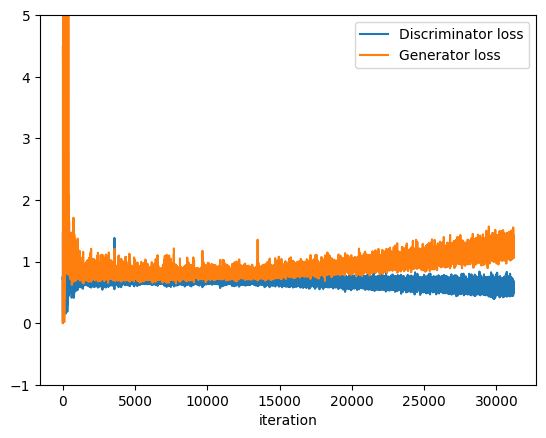

In [ ]:

# Depiction of loss function
fig, ax = plt.subplots()
plt.plot(d_loss_list,label='Discriminator loss')
plt.plot(g_loss_list,label='Generator loss')
ax.set_xlabel("iteration")
ax.set_ylim([-1,5])
plt.legend()
plt.show()